# Table of contents

### - Import libraries and define functions + Initial setup

### - Import data

### - Make Plots & Tables

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from scipy import stats
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import os
import glob


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    return df_transcript_length    

In [3]:
"""
Convert a hexadecimal color representation to an RGB tuple.

Parameters:
hex_color (str): The color in hexadecimal format. Can start with or without a hash (#).
                  It should be 6 characters long, with each pair representing red, green,
                  and blue color channels respectively.

Returns:
tuple: A tuple containing three integers representing the red, green, and blue color
       values ranging from 0 to 255.
"""

def hex_to_rgb(hex_color: str) -> tuple:

    # Remove the hash at the start if it's there
    hex_color = hex_color.lstrip('#')
    # Convert hex to RGB by taking two characters at a time, and converting to decimal
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [4]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    annotation = annotation.loc[annotation["type"] == "transcript"].copy()
    
    df_transcript_length = df_transcript_length.merge(annotation[["gene_id", "transcript_id"]], on="transcript_id", how="inner")
    
    return df_transcript_length    

In [5]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [6]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [7]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [8]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [9]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

### Import data

In [10]:
## Import and parse through extended annotations
ref = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, comment="#", names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


ref_length = get_real_transcript_length(ref)

In [11]:
## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../references/medically_relevant_genes_02-04-2023_UPDATED.tsv", sep="\t")

In [12]:
ref_length.shape[0]

254642

In [13]:
disease_relevant_genes.head()

,gene_id,gene_name
0,ENSG00000000419,DPM1
1,ENSG00000000971,CFH
2,ENSG00000001084,GCLC
3,ENSG00000001497,LAS1L
4,ENSG00000001626,CFTR


In [14]:
## Only keep length for clinically relevant

ref_length_relevant = ref_length.merge(disease_relevant_genes, on="gene_id", how="inner")

In [15]:
## Fix column names and order

ref_length_relevant = ref_length_relevant[["gene_name", "gene_id", "transcript_id", "real_transcript_length"]].copy()

ref_length_relevant.columns = ["gene_name", "gene_id", "transcript_id", "transcript_length"]

In [16]:
## Import data for transcript level counts and fix column names

df = pd.read_csv("../../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df = fix_column_names(df, is_gene=False)

In [17]:
## Calculate CPM and drop count columns
df = calculate_cpm(df, is_gene=False)

df = df[df.columns.drop(list(df.filter(regex='counts')))].copy()

In [18]:
## Calculate median CPM
df["median_CPM"] = df[df.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [19]:
## Only keep relevant columns and then merge
df  = df[["gene_id", "transcript_id", "median_CPM"]].copy()

df_final = df.merge(ref_length_relevant, on=["gene_id", "transcript_id"], how="inner")

In [20]:
## Create binary for transcript length

df_final.loc[df_final["transcript_length"] > 2000, "category"] = "> 2000 nucleotides"

df_final.loc[~(df_final["transcript_length"] > 2000), "category"] = "≤ 2000 nucleotides"

In [22]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []

list_above_2000 = []
list_below_2000 = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    above_2000_num = df_final.loc[((df_final["median_CPM"] >= cpm_thresh) & (df_final["category"] == "> 2000 nucleotides"))].shape[0]
    below_2000_num = df_final.loc[((df_final["median_CPM"] >= cpm_thresh) & (df_final["category"] == "≤ 2000 nucleotides"))].shape[0]

    list_cpm_thresh.append(cpm_thresh)
        
    list_above_2000.append(above_2000_num)
    list_below_2000.append(below_2000_num)

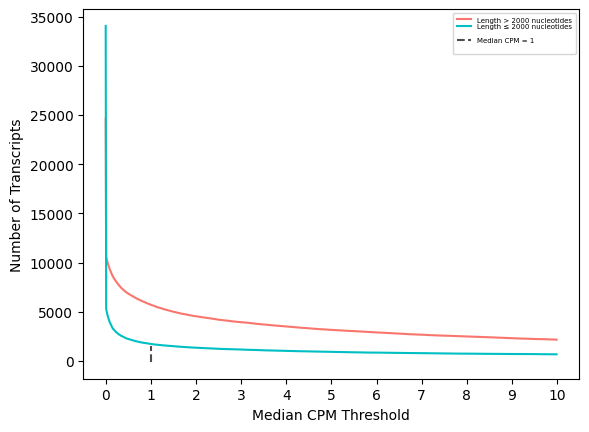

In [24]:
## Make plot showing number of transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_above_2000, color=ggplot2_colors[0], label="Length > 2000 nucleotides", linewidth=1.5, alpha=1)
plt.plot(list_cpm_thresh, list_below_2000, color=ggplot2_colors[4], label="Length ≤ 2000 nucleotides", linewidth=1.5, alpha=1)
plt.plot([1, 1], [-100, 1550], color="#4d4d4d", label="\nMedian CPM = 1\n", linewidth=1.5, alpha=1, linestyle='dashed')


plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of Transcripts')
plt.legend(loc="upper right", fontsize=5, borderpad=0.6, labelspacing=0.1)

#plt.savefig('../../figures/paper_figures/figure_2/number_of_new_transcripts_across_cpm_thresh.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()